In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
from scipy.spatial.distance import cdist
import seaborn as sns

## Loading and preparing data

### Loading INSEE codes
Download from [here](https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/export/). 


In [2]:
df = pd.read_csv('correspondance-code-insee-code-postal.csv', delimiter=";")[['Code Postal', 'Code INSEE', 'Population', 'geo_point_2d', 'Commune']]
df['population'] = (df['Population'].astype(float)*1000).apply(int)
df.drop_duplicates(inplace=True)

In [3]:
df.shape

(36742, 6)

In [4]:
df.head()

,Code Postal,Code INSEE,Population,geo_point_2d,Commune,population
0,63550,63402,0.3,"45.9381159052,3.61132640921",SAINT-VICTOR-MONTVIANEIX,300
1,26150,26027,0.2,"44.7264116116,5.30407617795",BARSAC,200
2,42940,42205,0.7,"45.655161946,3.9261116009",SAINT-BONNET-LE-COURREAU,700
3,69660,69063,3.8,"45.8220411914,4.8419319446",COLLONGES-AU-MONT-D'OR,3800
4,61360,61502,0.1,"48.4602912292,0.376581458211",VIDAI,100


### Prepare the data 

In [5]:
# df is something like
#      Code INSEE  Code Postal           Commune
# 1392      45234  45000/45100           ORLEANS
# 2528      63113  63000/63100  CLERMONT-FERRAND
# 4996      60048  60113/60190             BAUGY
# ..
# df_codes has index to code postal:
# 1392    [45000, 45100]
# 2528    [63000, 63100]
# 4996    [60113, 60190]
df_codes = df['Code Postal'].str.split('/')

# df_code_postal has the flat version of df_codes
#      Code Postal
# 1392       45000
# 1392       45100
# 2528       63000
# 2528       63100
# 4996       60113
# 4996       60190
df_code_postal = pd.concat(
    [pd.Series(codes, index=[index] * len(codes), name='Code Postal')
     for index, codes in df_codes.iteritems()]
).to_frame()

# join and reindex with original, giving
#      Code INSEE           Commune Code Postal
# 1392      45234           ORLEANS       45000
# 1392      45234           ORLEANS       45100
# 2528      63113  CLERMONT-FERRAND       63000
# 2528      63113  CLERMONT-FERRAND       63100
# 4996      60048             BAUGY       60113
# 4996      60048             BAUGY       60190
df = df.drop(columns='Code Postal').join(df_code_postal)
df['code_postal'] = df["Code Postal"].apply(str).str.zfill(5)
# reset index
df.reset_index(inplace=True, drop=True)

## Visualize the distributions and choose N 

### Population per city distribution

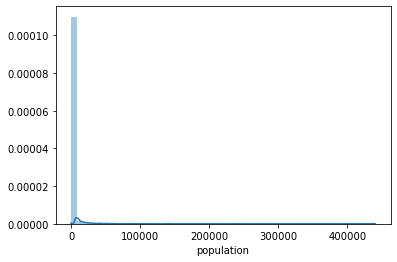

In [6]:
sns.distplot(df['population'])

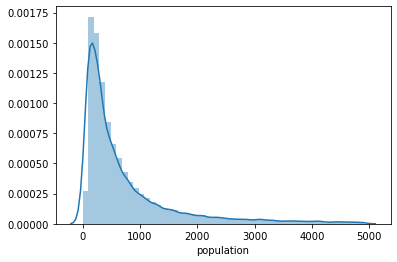

In [7]:
sns.distplot(df[df['population'] < 5000]['population'])

### Cumulative population

In [8]:
grouped = df.groupby(by=['population'])['population'].sum()
cumulative = np.cumsum(grouped) / grouped.sum()

In [9]:
def stats(inhabitants):
    print('< {} inhabitants: {:2.2%} of population, {} cities'.format(inhabitants, cumulative[inhabitants], df[df['population'] > inhabitants].shape[0]))

In [10]:
stats(1000), stats(2000), stats(3000)

< 1000 inhabitants: 12.87% of population, 9300 cities
< 2000 inhabitants: 20.81% of population, 5082 cities
< 3000 inhabitants: 25.88% of population, 3509 cities


(None, None, None)

In [11]:
cumulative[cumulative > 0.20].index[0]

1900

In [12]:
cumulative[1000], cumulative[2000], cumulative[3000], cumulative[5000]

(0.1287037109126629,
 0.2080644031111561,
 0.2587582365963101,
 0.3281325018231458)

In [13]:
df[df['population'] > 1000].shape[0], df[df['population'] > 2000].shape[0], df[df['population'] > 3000].shape[0], df[df['population'] > 5000].shape[0]

(9300, 5082, 3509, 2126)

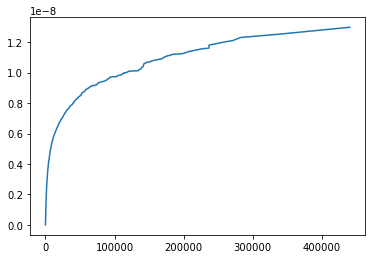

In [14]:
plt.plot(cumulative / grouped.sum())

* 22% of the French population lives in cities which have < 2000 inhabitants
* there are 3 700 cities with 3000+ inhabitants, which is roughly the number of healthcare facilities in France

## Generate mappings from postcode to closest postcode having more than N habitants

In [15]:
# Some postcodes are ambiguous because they correspond to many communes 
# Let us match them  to the commune with the greatest population 
# Small example:
#       Code INSEE    postal_code   population                Commune
# 31141      01344         10000        5400  SAINT-DENIS-LES-BOURG
# 6230       01053         10000       39600        BOURG-EN-BRESSE
# 12183      01183         10900        1300               GUEREINS
# 25930      01225         10900         400                  LURCY
# 23594      01258         10900        1100              MONTCEAUX
# 32294      01263         10900        3800    MONTMERLE-SUR-SAONE
# 7186       01169         10900         600            GENOUILLEUX
# 32418      01165         10900        1300           FRANCHELEINS
# 19343      01014         11000        3500                 ARBENT
# 21340      01031         11000        3500              BELLIGNAT

# calculate max index by code postal, giving
# 31141     6230   # << note this is the index not a integer position!
# 6230      6230
# 12183    32294
# 25930    32294
# 23594    32294
# 32294    32294
# 7186     32294
# 32418    32294
# 19343    19343
# 21340    19343
idx_max_pop = df.groupby('code_postal')['population'].apply(pd.Series.idxmax)

# Select using index
#         postal_code Code INSEE  population              Commune
# 6230          10000      01053       39600      BOURG-EN-BRESSE
# 6230          10000      01053       39600      BOURG-EN-BRESSE
# 32294         10900      01263        3800  MONTMERLE-SUR-SAONE
# 32294         10900      01263        3800  MONTMERLE-SUR-SAONE
# 32294         10900      01263        3800  MONTMERLE-SUR-SAONE
# 32294         10900      01263        3800  MONTMERLE-SUR-SAONE
# 32294         10900      01263        3800  MONTMERLE-SUR-SAONE
# 32294         10900      01263        3800  MONTMERLE-SUR-SAONE
# 19343         11000      01014        3500               ARBENT
# 19343         11000      01014        3500               ARBENT
df_max_pop = df.loc[idx_max_pop, ('code_postal', 'Code INSEE', 'population', 'Commune', 'geo_point_2d')]
df_max_pop.reset_index(inplace=True, drop=True)

In [16]:
df = df_max_pop

In [17]:
N = cumulative[cumulative > 0.20].index[0]
df = pd.concat([df, df['geo_point_2d'].str.split(',').apply(pd.Series).rename(columns={0:'lattitude', 1:'longitude'})], axis=1)
df_less = df[df['population'] < N]
df_more = df[df['population'] >= N]

In [18]:
ref_column = 'code_postal' 
assert not set(df_less[ref_column]).intersection(set(df_more[ref_column])) 

In [19]:
# pairwise distance between those two subsets 
geo_cdist = cdist(df_less[['lattitude', 'longitude']], df_more[['lattitude', 'longitude']])
closest_index = np.argmin(geo_cdist, axis=1)

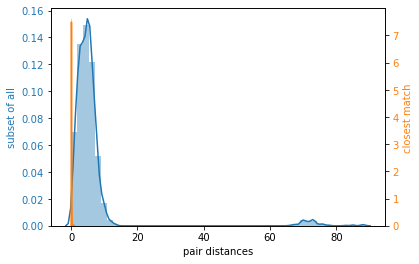

In [20]:
# check that the nearest matched commune is 'near enough', compared to usual pairwise distance
all_distances = list(geo_cdist.reshape(-1, 1)[:,0])
match_distances = np.min(geo_cdist, axis=1)

subset_distances = random.sample(all_distances, geo_cdist.shape[0])
f, ax1 = plt.subplots()
ax1.set_xlabel('pair distances')
ax1.set_ylabel('subset of all', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
sns.distplot(subset_distances, ax=ax1, label='all')
ax2 = ax1.twinx()
ax2.set_ylabel('closest match', color='C1') 
ax2.tick_params(axis='y', labelcolor='C1')
sns.distplot(match_distances, ax=ax2, color='C1', label='nearest match')

In [21]:
# pairwise distance between those two subsets 
geo_cdist = cdist(df_less[['lattitude', 'longitude']], df_more[['lattitude', 'longitude']])
closest_index = np.argmin(geo_cdist, axis=1)
# if population under threshold, match is closest municipality (min geo dist) amonngst those with population above threshold
match_values = np.array([df_more.iloc[i][ref_column] for i in closest_index])
# if population above threshold, match is self 
df[f'match_{ref_column}'] = df[ref_column]
df.loc[df_less.index, f'match_{ref_column}'] = match_values
df.head(15)

,code_postal,Code INSEE,population,Commune,geo_point_2d,lattitude,longitude,match_code_postal
0,01000,01053,39600,BOURG-EN-BRESSE,"46.2051520382,5.24602125501",46.2051520382,5.24602125501,01000
1,01090,01263,3800,MONTMERLE-SUR-SAONE,"46.0849573236,4.7608579486",46.0849573236,4.7608579486,01090
2,01100,01283,22900,OYONNAX,"46.2605435859,5.65344320923",46.2605435859,5.65344320923,01100
3,01110,01185,4100,HAUTEVILLE-LOMPNES,"45.9696520061,5.57627261783",45.9696520061,5.57627261783,01110
4,01120,01262,6900,MONTLUEL,"45.8909006209,5.01987566185",45.8909006209,5.01987566185,01120
5,01130,01269,3600,NANTUA,"46.1537845403,5.61352793799",46.1537845403,5.61352793799,01130
6,01140,01348,2700,SAINT-DIDIER-SUR-CHALARONNE,"46.1840408682,4.81645666173",46.1840408682,4.81645666173,01140
7,01150,01202,6700,LAGNIEU,"45.8917015798,5.32917518895",45.8917015798,5.32917518895,01150
8,01160,01304,2600,PONT-D'AIN,"46.0542077091,5.34703652618",46.0542077091,5.34703652618,01160
9,01170,01173,9900,GEX,"46.3471891747,6.04650555568",46.3471891747,6.04650555568,01170


In [22]:
# test matching is correct 
def test_row(row):
    # if population greater than threshold
    if row['population'] < N: 
        # assert ref_column match differs
        assert row[ref_column] != row[f'match_{ref_column}']
        # assert ref_column match has its population above threshold 
        df[df[ref_column] == row[ref_column]]['population'] >= N
    else: # 
        # assert INSEE match is self 
        assert row[ref_column] == row[f'match_{ref_column}']
n_rows = 1000 # set -1 to test the entire dataframe 
for k, row in df.iloc[:n_rows].iterrows():
    test_row(row)

In [23]:
df.head()

,code_postal,Code INSEE,population,Commune,geo_point_2d,lattitude,longitude,match_code_postal
0,01000,01053,39600,BOURG-EN-BRESSE,"46.2051520382,5.24602125501",46.2051520382,5.24602125501,01000
1,01090,01263,3800,MONTMERLE-SUR-SAONE,"46.0849573236,4.7608579486",46.0849573236,4.7608579486,01090
2,01100,01283,22900,OYONNAX,"46.2605435859,5.65344320923",46.2605435859,5.65344320923,01100
3,01110,01185,4100,HAUTEVILLE-LOMPNES,"45.9696520061,5.57627261783",45.9696520061,5.57627261783,01110
4,01120,01262,6900,MONTLUEL,"45.8909006209,5.01987566185",45.8909006209,5.01987566185,01120


# Dump to json 

In [25]:
# dump to JSON 
matching_dict = dict(zip(df['code_postal'], df['match_code_postal']))
with open('closest_zip.json', 'w') as outfile:
    json.dump(matching_dict, outfile)